In [1]:
# Google Drive 연동
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython import display

import os
from tqdm import tqdm
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [3]:
# Load Pocketmon Dataset
def find_path(path):
    file_list = os.listdir(path)
    return file_list

def png_to_np(path, file_list, read_type='rgb'):
    pix = []
    for idx in tqdm(range(len(file_list))):
      file_name = file_list[idx]
      if read_type == "rgb":
        image = PIL.Image.open(path + '/' + file_name) # (256, 256, 3)
      elif read_type == "gray":
        image = PIL.Image.open(path + '/' + file_name).convert("L") # (256, 256, 1)
      np_image = np.array(image).astype(np.float32) / 255.0
      pix.append(np_image)
    return pix

In [4]:
path = 'drive/MyDrive/dataset/jpg/jpg_dataset_32'

file_list = find_path(path)

In [5]:
images = png_to_np(path, file_list, 'rgb')

100%|██████████| 898/898 [07:07<00:00,  2.10it/s]


In [6]:
train_dataset = np.array(images[:768])
test_dataset = np.array(images[768:])

#train_dataset = train_dataset.reshape(768, 3072)
#test_dataset = test_dataset.reshape(130, 3072)

#train_dataset = train_dataset[..., tf.newaxis]
#test_dataset = test_dataset[..., tf.newaxis]

len(train_dataset), len(test_dataset)

(768, 130)

In [7]:
train_size = 768
batch_size = 8
test_size = 130

In [8]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_dataset)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_dataset)
                .shuffle(test_size).batch(batch_size))

In [9]:
train_dataset, test_dataset

(<BatchDataset shapes: (None, 3072), types: tf.float32>,
 <BatchDataset shapes: (None, 3072), types: tf.float32>)

In [ ]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.leaky_relu = tf.keras.layers.LeakyReLU()
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),
            
            tf.keras.layers.Conv2D(filters=16, kernel_size=5, strides=(2, 2), activation=self.leaky_relu, padding="same"),    # 32, 32, 1 -> 16, 16, 16
            
            tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=(2, 2), activation=self.leaky_relu, padding="same"),    # 16, 16, 16 -> 8, 8, 32
         
            #tf.keras.layers.Conv2D(filters=64, kernel_size=2, strides=(2, 2), activation=self.leaky_relu, padding="same"),    # 64, 64, 32 -> 32, 32, 64 => 63,488
         
            #tf.keras.layers.Conv2D(filters=256, kernel_size=2, strides=(2, 2), activation=self.leaky_relu, padding="vaild"),  # 32, 32, 128 -> 16, 16, 256 
         
            #tf.keras.layers.Conv2D(filters=512, kernel_size=2, strides=(2, 2), activation=self.leaky_relu, padding="vaild"),  # 16, 16, 256 -> 8, 8, 512
            
            tf.keras.layers.Flatten(),                                            # 8 * 8 * 32
            
            # No activation
            tf.keras.layers.Dense(4),                                            # 63,488 -> 4
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(2,)),
            
            tf.keras.layers.Dense(units=8 * 8 * 32),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
            
            #tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2, strides=2, padding="valid", activation=self.leaky_relu, dilation_rate=(2, 2)),

            #tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=2, strides=2, padding="valid", activation=self.leaky_relu, dilation_rate=(2, 2)),
            
            #tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding="same", activation=self.leaky_relu),
         
            tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding="same", activation=self.leaky_relu), # 8, 8, 32 -> 16, 16, 16

            tf.keras.layers.Conv2DTranspose(filters=8, kernel_size=5, strides=2, padding="same", activation=self.leaky_relu), # 16, 16, 16 -> 32, 32, 8
  
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=5, strides=1, padding="same", activation=self.leaky_relu)  # 32, 32, 8 -> 32, 32, 3
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
epochs = 10000
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 8

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [ ]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, :])
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  #plt.savefig('./drive/MyDrive/result_image/jpg_32/color_image_at_epoch_{:03d}.png'.format(epoch))
  plt.show()

In [ ]:
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 10000, Test set ELBO: -1088.2205810546875, time elapse for current epoch: 0.23458576202392578


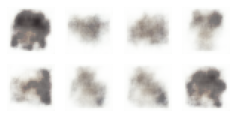

100%|██████████| 10000/10000 [1:46:12<00:00,  1.57it/s]


'\nplt.subplot(211)\nplt.plot(losses)\nplt.subplot(212)\nplt.plot(elboes)\nplt.show()'

In [ ]:
generate_and_save_images(model, 0, test_sample)

losses = []
elboes = []

for epoch in tqdm(range(1, epochs + 1)):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  losses.append(loss)
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  elboes.append(elbo)
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)
'''
plt.subplot(211)
plt.plot(losses)
plt.subplot(212)
plt.plot(elboes)
plt.show()'''

In [ ]:
'''
encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),
            
            tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=(2, 2), padding='same'),    # 256, 256, 3 -> 128, 128, 32
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=(2, 2), padding='same'),    # 128, 128, 32 -> 64, 64, 64
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=(2, 2), padding='same'),   # 64, 64, 64 -> 32, 32, 128 => 131,072
            tf.keras.layers.LeakyReLU(),
         
            #tf.keras.layers.Conv2D(filters=256, kernel_size=2, strides=(2, 2)),   # 32, 32, 128 -> 16, 16, 256 
            #tf.keras.layers.LeakyReLU(),
         
            #tf.keras.layers.Conv2D(filters=512, kernel_size=2, strides=(2, 2)),   # 16, 16, 256 -> 8, 8, 512
            #tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Flatten(),                                            # 8, 8, 512 -> 8 * 8 * 512 = 32768
            
            # No activation
            tf.keras.layers.Dense(32),                                            # 32768 -> 32
        ]
    )
decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(16,)),
            
            tf.keras.layers.Dense(units=16 * 16 * 256),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape(target_shape=(16, 16, 256)),
            
            #tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=2, strides=2, padding='same'),
            #tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=5, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=5, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
         
            tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=5, strides=2, padding='same'),
            tf.keras.layers.LeakyReLU(),
            
            tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=2, strides=1, padding='same')

        ]
    )

encoder.summary()
decoder.summary()
'''

"\nencoder = tf.keras.Sequential(\n        [\n            tf.keras.layers.InputLayer(input_shape=(256, 256, 3)),\n            \n            tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=(2, 2), padding='same'),    # 256, 256, 3 -> 128, 128, 32\n            tf.keras.layers.LeakyReLU(),\n            \n            tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=(2, 2), padding='same'),    # 128, 128, 32 -> 64, 64, 64\n            tf.keras.layers.LeakyReLU(),\n         \n            tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=(2, 2), padding='same'),   # 64, 64, 64 -> 32, 32, 128 => 131,072\n            tf.keras.layers.LeakyReLU(),\n         \n            #tf.keras.layers.Conv2D(filters=256, kernel_size=2, strides=(2, 2)),   # 32, 32, 128 -> 16, 16, 256 \n            #tf.keras.layers.LeakyReLU(),\n         \n            #tf.keras.layers.Conv2D(filters=512, kernel_size=2, strides=(2, 2)),   # 16, 16, 256 -> 8, 8, 512\n            #tf.keras.layers.LeakyRe